In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ptitprince as pt 
import seaborn as sns
import geopandas as gpd
import os 
import re
pd.set_option('display.max_colwidth', None)

In [2]:
# geopandas loads
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [3]:

# import kml files 
regex_region = r"(\d+).kml"
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
files = os.listdir('../data/kml')
geography_information = []
for file in files: 
    region_id = int(re.search(regex_region, file).group(1))
    d = gpd.read_file(f'../data/kml/{file}', driver='KML')
    d['region_id'] = region_id
    geography_information.append(d)
geography_information = pd.concat(geography_information)
geography_information = geography_information[['Name', 'geometry', 'region_id']]
geography_centroid = geography_information.assign(geometry = lambda x: x['geometry'].centroid)


/tmp/ipykernel_20098/1945463822.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geography_centroid = geography_information.assign(geometry = lambda x: x['geometry'].centroid)


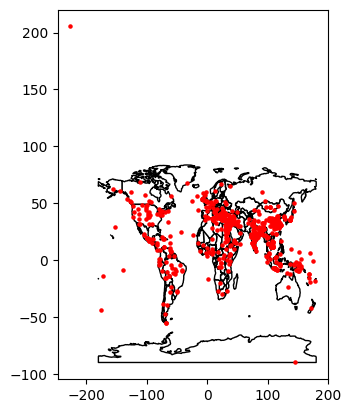

In [4]:
# clearly something wrong with the Unitarian Univeralist Organizations y-coordinate
base = world.plot(color = 'white', edgecolor = 'black')
geography_centroid.plot(ax=base, marker='o', color='red', markersize=5)
plt.show();

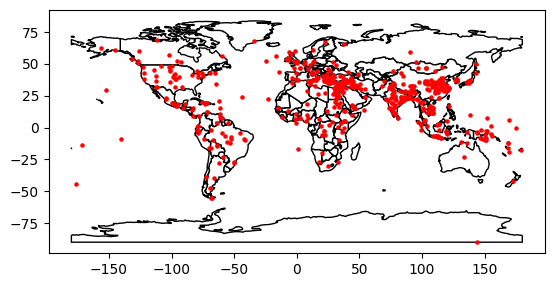

In [5]:
# remove the weird point (n = 626)
geography_filtered = geography_centroid[geography_centroid['Name'] != 'Unitarian Univeralist Organizations']
base = world.plot(color = 'white', edgecolor = 'black')
geography_filtered.plot(ax=base, marker='o', color='red', markersize=5)
plt.show();

/tmp/ipykernel_20098/1898036713.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('../data/raw/drh_20221019.csv')


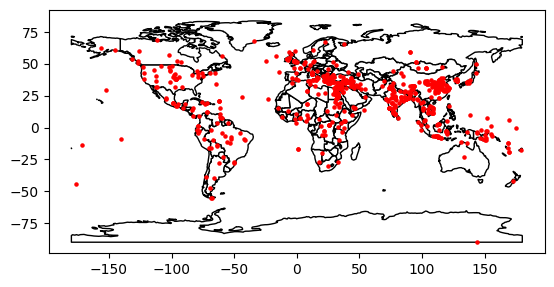

In [6]:
# match with our data
data_raw = pd.read_csv('../data/raw/drh_20221019.csv')
data_geography = data_raw[['entry_name', 'entry_id', 'region_id']].drop_duplicates()

# merge with our full data set (n = 755 so some overlap)
geography_merge = geography_filtered.merge(data_geography, on = 'region_id', how = 'inner')
base = world.plot(color = 'white', edgecolor = 'black')
geography_merge.plot(ax=base, marker='o', color='red', markersize=5)
plt.show();

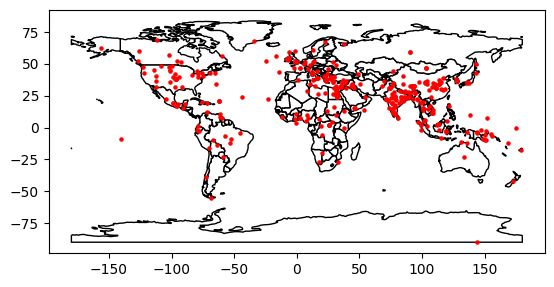

In [7]:
# merge with the subset that we use in the Entropy paper (n = 370)
entry_reference = pd.read_csv('../data/preprocessing/entry_reference.csv')
geography_sub = geography_merge.merge(entry_reference, on = ['entry_id', 'entry_name'], how = 'inner')
base = world.plot(color = 'white', edgecolor = 'black')
geography_sub.plot(ax=base, marker='o', color='red', markersize=5)
plt.show();


In [15]:
# only 370/407 entries with regions but we have 407 total entries
# which ones do not have a region? 
list(set(set(entry_reference['entry_name'])) - set(set(geography_sub['entry_name'])))[0:5]


['Order of the Hermits of St Augustine (Augustinian friars)',
 'Anomeans',
 'Twofold Mystery (Chongxuan 重玄)',
 "Tunisian Women's Associations",
 'Early Missionary Christianity in China']

In [17]:
# Check one of them: https://religiondatabase.org/browse/1415/#/
# looks like they should have a region but it is not in my original file it seems. 
entry_reference[entry_reference['entry_name'] == 'Anomeans']

,entry_id,entry_name
389,1415,Anomeans


In [18]:
# Ah, it is in my original file, but I do not have a .kml file corresponding 
# to region 1573. 
data_geography[data_geography['entry_id'] == 1415]

,entry_name,entry_id,region_id
74471,Anomeans,1415,1573


In [11]:
# Q: why are we lacking region for 60 cases when 407-370 = 37?
# A: some entry_names have more  than one region
geography_sub.groupby('entry_name').size().reset_index(name='counts').sort_values('counts', ascending=False).head(5)


,entry_name,counts
89,Free Methodist Church,2
31,Bahinabai Chaudhari's Songs: A Performance Tradition in Maharashtra,2
246,Russian Orthodox Mission in Alaska,2
80,Drukpa Kagyü School (Bhutan),2
275,Swaminarayan Sampraday,2


In [12]:
# for instance the Free Methodist Church
geography_sub[geography_sub['entry_name'] == "Free Methodist Church"]

,Name,geometry,region_id,entry_name,entry_id
50,Free Methodist World Conference.,POINT (-43.66517 24.28490),1103,Free Methodist Church,879
51,Free Methodist World Conference,POINT (-6.32814 59.25812),1037,Free Methodist Church,879
